In [1]:
import numpy as np
import tensorflow.keras.datasets.mnist as mnist

import sys
sys.path.append('../Neural_Network_from_Scratch')
import optimizers as opt

import matplotlib.pyplot as plt
import plotly.graph_objs as go

In [2]:
# Load data from tensorflow
data = mnist.load_data()

In [3]:
(x_train, y_train), (x_test, y_test) = data

In [4]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

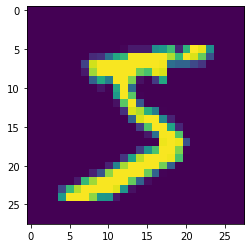

In [5]:
plt.imshow(x_train[0])

In [6]:
# Preprocess data
# Reshape (flatten)
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)
print(x_train.shape, x_test.shape)

# Normalize data within {0,1} + dtype conversion
x_train = np.array(x_train/255., dtype=np.float32)
x_test = np.array(x_test/255., dtype=np.float32)

(60000, 784) (10000, 784)


In [7]:
# Function to convert labels to one-hot encodings
def one_hot(Y):
    num_labels = len(set(Y))
    new_Y = []
    for label in Y:
        encoding = np.zeros(num_labels)
        encoding[label] = 1.
        new_Y.append(encoding)
    return np.array(new_Y)

In [8]:
y_train = one_hot(y_train)
y_test = one_hot(y_test)
y_train.shape, y_test.shape

((60000, 10), (10000, 10))

In [9]:
# Layer object to handle weights, biases, activation (if any) of a layer

class Layer:
    def __init__(self, hidden_units: int, activation:str=None):
        self.hidden_units = hidden_units
        self.activation = activation
        self.W = None
        self.b = None
        
    def initialize_params(self, n_in, hidden_units):
        params = dict()
        np.random.seed(42)
        self.W = np.random.randn(n_in, hidden_units) * np.sqrt(2/n_in) 
        np.random.seed(42)
        self.b = np.zeros((1, hidden_units))
    
    def forward(self, X):
        self.input = np.array(X, copy=True)
        if self.W is None:
            self.initialize_params(self.input.shape[-1], self.hidden_units)

        self.Z = X @ self.W + self.b
        
        if self.activation is not None:
            self.A = self.activation_fn(self.Z)
            return self.A
        return self.Z
    
    def activation_fn(self, z, derivative=False):
        if self.activation == 'relu':
            if derivative:
                return self.drelu(z)
            return self.relu(z)
        if self.activation == 'sigmoid':
            if derivative:
                return self.dsigmoid(z)
            return self.sigmoid(z)
        if self.activation == 'softmax':
            if derivative: 
                return self.dsoftmax(z)
            return self.softmax(z)

    @staticmethod
    def sigmoid(z):
        return 1 / (1 + np.exp(-z))

    @staticmethod
    def dsigmoid(z):
        return Layer.sigmoid(z) * (1-Layer.sigmoid(z))

    @staticmethod
    def relu(z):
        return np.maximum(0, z)

    @staticmethod
    def drelu(z):
        return np.where(z<=0,0,1)

    @staticmethod
    def softmax(x):  # numerically stable version of softmax 
        exp = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp / np.sum(exp, axis=1, keepdims=True)

    @staticmethod
    def dsoftmax(x):
        exp = np.exp(x - np.max(x, axis=1, keepdims=True)) 
        return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))

    def __repr__(self):
        return str(f'''Hidden Units={self.hidden_units}; Activation={self.activation}''')

In [10]:
class Model:
    def __init__(self):
        self.layers = dict()
        self.cache = dict()
        self.grads = dict()
        
    def add(self, layer):
        self.layers[len(self.layers)+1] = layer
        
    def set_config(self, epochs, learning_rate, optimizer=None):
        self.epochs = epochs
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        if not not self.optimizer:
            self.optimizer.config(self.layers)
            self.optimizer.epochs = self.epochs
            self.optimizer.learning_rate = self.learning_rate

    def forward(self, x):
        for idx, layer in self.layers.items():
            x = layer.forward(x)
            self.cache[f'W{idx}'] = layer.W
            self.cache[f'Z{idx}'] = layer.Z
            self.cache[f'A{idx}'] = layer.A
        return x

    def backward(self, y):
        last_layer_idx = max(self.layers.keys())
        m = y.shape[0]
        # back prop through all dZs 
        for idx in reversed(range(1, last_layer_idx+1)):
            if idx == last_layer_idx:
                # e.g. dZ3 = y_pred - y_true for a 3 layer network 
                self.grads[f'dZ{idx}'] = self.cache[f'A{idx}'] - y
            else:
                # dZn = dZ(n+1) dot W(n+1) * inverse derivative of activation function of Layer n, with Zn as input 
                self.grads[f'dZ{idx}'] = self.grads[f'dZ{idx+1}'] @ self.cache[f'W{idx+1}'].T * self.layers[idx].activation_fn(self.cache[f'Z{idx}'], derivative=True)
            self.grads[f'dW{idx}'] = 1 / m * self.layers[idx].input.T @ self.grads[f'dZ{idx}']
            self.grads[f'db{idx}'] = 1 / m * np.sum(self.grads[f'dZ{idx}'], axis=0, keepdims=True)
            
            assert self.grads[f'dW{idx}'].shape == self.cache[f'W{idx}'].shape

    def update_params(self, epoch_num, steps):
        for idx in self.layers.keys():
            if self.optimizer is None:
                self.optimize(idx)
            else:
                self.optimizer.optimize(idx, self.layers, self.grads, epoch_num, steps)                
 
    def optimize(self, idx):  
        self.layers[idx].W -= self.learning_rate * self.grads[f'dW{idx}']
        self.layers[idx].b -= self.learning_rate * self.grads[f'db{idx}']
        
    def fit(self, x_train, y_train, x_test=None, y_test=None, batch_size=32):
        '''Training cycle of the model object'''
        losses = []
        train_accs = []
        val_accs = []

        for i in range(1, self.epochs+1):
            print(f'Epoch {i}')
            batches = self.create_batches(x_train, y_train, batch_size)
            epoch_loss = []
            steps = 0
            
            for x, y in batches:
                steps += 1
                preds = self.forward(x)
                loss = self.compute_loss(y, preds)
                epoch_loss.append(loss)

                # Backward propagation - calculation of gradients 
                self.backward(y)
                
                # update weights and biases of each layer
                self.update_params(i, steps)
                
            loss = sum(epoch_loss) / len(epoch_loss)
            losses.append(loss)

            # Predict with network on x_train
            train_preds = self.forward(x_train)
            c = np.argmax(train_preds, axis=1) == np.argmax(y_train, axis=1)
            train_acc = list(c).count(True) / len(c) * 100
            train_accs.append(train_acc)
            
            # Predict with network on x_test
            if x_test is not None:
                test_preds = self.forward(x_test)
                c = np.argmax(test_preds, axis=1) == np.argmax(y_test, axis=1)
                val_acc = list(c).count(True)/len(c) * 100
                val_accs.append(val_acc)

                print(f'Loss:{loss} Train Acc: {train_acc} Val Acc: {val_acc}')
            else:
                print(f'Loss:{loss} Train Acc: {train_acc}')
            
                
        self.history = {'train_loss': losses, 'train_acc': train_accs, 'val_acc': val_accs}

    @staticmethod
    def compute_loss(Y, Y_hat):
        m = Y.shape[0]
        L = -1./m * np.sum(Y * np.log(Y_hat))
        return L

    @staticmethod
    def mse(Y, Y_hat):
        m = Y.shape[0]
        return np.mean((Y- Y_hat)**2)
    
    @staticmethod
    def create_batches(x, y, batch_size):
        m = x.shape[0]
        num_batches = m / batch_size
        batches = []
        for i in range(int(num_batches+1)):
            batch_x = x[i*batch_size:(i+1)*batch_size]
            batch_y = y[i*batch_size:(i+1)*batch_size]
            batches.append((batch_x, batch_y))
        
        # without this, batch sizes that are perfectly divisible will create an 
        # empty array at index -1
        if m % batch_size == 0:
            batches.pop(-1)

        return batches
    
    def __repr__(self):
        return str(self.layers)

In [11]:
epochs = 20
lr = 1e-3
batch_size = 128
lr_decay = False

In [12]:
def run_model(optimizer=None):
    model = Model()
    model.add(Layer(128, activation='relu'))
    model.add(Layer(64, activation='relu'))
    model.add(Layer(10, activation='softmax'))
    model.set_config(epochs=epochs, learning_rate=lr, optimizer=optimizer)

    model.fit(x_train, y_train, x_test, y_test, batch_size=batch_size)
    return model.history

In [15]:
# Demon stands for decaying momentum from this paper : https://arxiv.org/pdf/1910.04952v3.pdf
# Momentum optimizers 
sgdm = opt.SGDM(lr, name='SGDM')
demonSGDM = opt.SGDM(lr, demon=True, name='DemonSGDM')
qhm = opt.QHM(lr, name='QHM')
nesterov = opt.Nesterov(lr, name='Nesterov')
demonNesterov = opt.Nesterov(lr, demon=True, name='DemonNesterov')

adagrad = opt.Adagrad(lr, name='Adagrad')
rmsprop = opt.RMSprop(lr, name='RMSprop')
adadelta = opt.Adadelta(lr, name='Adadelta')

In [16]:
# Adam family
# Weight_decay is the implementation in the AdamW paper 
adam = opt.Adam(lr, name='Adam')
adamW = opt.Adam(lr, weight_decay=True, name='AdamW')
demonAdam = opt.Adam(lr, demon=True, name='DemonAdam')
demonAdamW = opt.Adam(lr, weight_decay=True, demon=True, name='DemonAdamW')

NAdam = opt.Nadam(lr, name='NAdam')
NAdamW = opt.Nadam(lr, weight_decay=True, name='NAdamW')
demonNAdam = opt.Nadam(lr, demon=True, name='DemonNAdam')
demonNAdamW = opt.Nadam(lr, weight_decay=True, demon=True, name='DemonNAdamW')

adamax = opt.Adamax(lr, name='Adamax')
adamaxW = opt.Adamax(lr, weight_decay=True, name='AdamaxW')
demonAdamax = opt.Adamax(lr, demon=True, name='DemonAdamax')
demonAdamaxW = opt.Adamax(lr, weight_decay=True, demon=True, name='DemonAdamaxW')

QHAdam = opt.QHAdam(lr, name='QHAdam')
QHAdamW = opt.QHAdam(lr, weight_decay=True, name='QHAdamW')
demonQHAdam = opt.QHAdam(lr, demon=True, name='DemonQHAdam')
demonQHAdamW = opt.QHAdam(lr, weight_decay=True, demon=True, name='DemonQHAdamW')


In [17]:
opts1 = [sgdm, demonSGDM, qhm, nesterov, demonNesterov, adagrad, rmsprop, adadelta]

In [18]:
opts2 = [adam, adamW, demonAdam, demonAdamW, NAdam, NAdamW, demonNAdam, demonNAdamW, 
         adamax, adamaxW, demonAdamax, demonAdamaxW, QHAdam, QHAdamW, demonQHAdam, demonQHAdamW]

In [23]:
opts = opts1 + opts2
opts

In [24]:
opts_history = {i.name: run_model(i) for i in opts}

Epoch 1
Loss:1.971548086743485 Train Acc: 60.940000000000005 Val Acc: 61.78
Epoch 2
Loss:1.250420248838212 Train Acc: 77.28833333333334 Val Acc: 78.38000000000001
Epoch 3
Loss:0.7758959326613197 Train Acc: 84.01666666666667 Val Acc: 85.24000000000001
Epoch 4
Loss:0.5239670911303634 Train Acc: 87.92999999999999 Val Acc: 88.99000000000001
Epoch 5
Loss:0.3382509386365137 Train Acc: 92.72666666666667 Val Acc: 93.05
Epoch 6
Loss:0.2160378233607533 Train Acc: 94.80333333333333 Val Acc: 94.69999999999999
Epoch 7
Loss:0.16188467669077286 Train Acc: 96.2 Val Acc: 96.0
Epoch 8
Loss:0.13054313307258283 Train Acc: 96.65333333333334 Val Acc: 96.34
Epoch 9
Loss:0.1108617285036437 Train Acc: 97.29166666666667 Val Acc: 96.71
Epoch 10
Loss:0.09447141691313259 Train Acc: 97.615 Val Acc: 96.84
Epoch 11
Loss:0.07913496700905819 Train Acc: 97.79666666666667 Val Acc: 96.81
Epoch 12
Loss:0.06897837086191724 Train Acc: 97.925 Val Acc: 96.74000000000001
Epoch 13
Loss:0.06206052102064375 Train Acc: 97.998333333

Loss:0.28994856193572865 Train Acc: 92.085 Val Acc: 92.46
Epoch 10
Loss:0.2817776924594709 Train Acc: 92.28333333333333 Val Acc: 92.58999999999999
Epoch 11
Loss:0.27458352316899004 Train Acc: 92.47 Val Acc: 92.78
Epoch 12
Loss:0.26814711451079226 Train Acc: 92.64166666666667 Val Acc: 92.96
Epoch 13
Loss:0.2623137886995826 Train Acc: 92.785 Val Acc: 93.07
Epoch 14
Loss:0.2569929493961753 Train Acc: 92.93666666666667 Val Acc: 93.17999999999999
Epoch 15
Loss:0.25209256177888256 Train Acc: 93.035 Val Acc: 93.25
Epoch 16
Loss:0.24753349497390942 Train Acc: 93.16166666666666 Val Acc: 93.37
Epoch 17
Loss:0.2432614575322403 Train Acc: 93.27499999999999 Val Acc: 93.52000000000001
Epoch 18
Loss:0.23923434705047805 Train Acc: 93.37333333333333 Val Acc: 93.60000000000001
Epoch 19
Loss:0.23542810919125237 Train Acc: 93.46333333333334 Val Acc: 93.66
Epoch 20
Loss:0.23184784085697988 Train Acc: 93.57 Val Acc: 93.78999999999999
Epoch 1
Loss:0.3494961630785522 Train Acc: 93.50666666666667 Val Acc: 93.2

Loss:0.014178155887311703 Train Acc: 99.43333333333332 Val Acc: 97.58
Epoch 17
Loss:0.012253706645026983 Train Acc: 99.515 Val Acc: 97.63
Epoch 18
Loss:0.010595784027540469 Train Acc: 99.50666666666666 Val Acc: 97.58
Epoch 19
Loss:0.009213784338289014 Train Acc: 99.57166666666667 Val Acc: 97.65
Epoch 20
Loss:0.008039320337332293 Train Acc: 99.38166666666667 Val Acc: 97.46000000000001
Epoch 1
Loss:0.3466096925089451 Train Acc: 94.63000000000001 Val Acc: 94.42
Epoch 2
Loss:0.14803258841396658 Train Acc: 96.11666666666666 Val Acc: 95.5
Epoch 3
Loss:0.11072932136290548 Train Acc: 97.11833333333333 Val Acc: 96.52
Epoch 4
Loss:0.0885864731584125 Train Acc: 97.65166666666667 Val Acc: 96.88
Epoch 5
Loss:0.07329138452387216 Train Acc: 98.02666666666666 Val Acc: 97.11
Epoch 6
Loss:0.06192593411986874 Train Acc: 98.28833333333333 Val Acc: 97.21
Epoch 7
Loss:0.052738580067773363 Train Acc: 98.52499999999999 Val Acc: 97.37
Epoch 8
Loss:0.04525772289855424 Train Acc: 98.72833333333332 Val Acc: 97.39

Loss:0.3531753695219789 Train Acc: 91.08333333333334 Val Acc: 91.59
Epoch 4
Loss:0.30761378067950385 Train Acc: 91.97666666666666 Val Acc: 92.35
Epoch 5
Loss:0.2787598133094216 Train Acc: 92.61 Val Acc: 92.99
Epoch 6
Loss:0.2571553470956499 Train Acc: 93.14333333333333 Val Acc: 93.47999999999999
Epoch 7
Loss:0.23938363252245923 Train Acc: 93.60333333333334 Val Acc: 93.81
Epoch 8
Loss:0.22425914754146434 Train Acc: 94.01833333333333 Val Acc: 94.04
Epoch 9
Loss:0.2112139834034975 Train Acc: 94.34166666666667 Val Acc: 94.36
Epoch 10
Loss:0.19980202596668398 Train Acc: 94.64666666666666 Val Acc: 94.62
Epoch 11
Loss:0.1897602969881926 Train Acc: 94.89166666666667 Val Acc: 94.87
Epoch 12
Loss:0.18085804369809824 Train Acc: 95.12666666666667 Val Acc: 95.07
Epoch 13
Loss:0.17287640880367106 Train Acc: 95.34666666666666 Val Acc: 95.21
Epoch 14
Loss:0.16567168984416727 Train Acc: 95.53666666666668 Val Acc: 95.36
Epoch 15
Loss:0.15910550063302167 Train Acc: 95.73333333333333 Val Acc: 95.55
Epoch 

Loss:0.03300715642795326 Train Acc: 98.85000000000001 Val Acc: 97.39999999999999
Epoch 11
Loss:0.02866261822065572 Train Acc: 98.99333333333334 Val Acc: 97.46000000000001
Epoch 12
Loss:0.024774177824879656 Train Acc: 99.09666666666666 Val Acc: 97.47
Epoch 13
Loss:0.021464150281812106 Train Acc: 99.21833333333333 Val Acc: 97.55
Epoch 14
Loss:0.018443837829816855 Train Acc: 99.26166666666667 Val Acc: 97.50999999999999
Epoch 15
Loss:0.01598987057260612 Train Acc: 99.41499999999999 Val Acc: 97.50999999999999
Epoch 16
Loss:0.013841694731086965 Train Acc: 99.48 Val Acc: 97.56
Epoch 17
Loss:0.011926170272867487 Train Acc: 99.555 Val Acc: 97.61999999999999
Epoch 18
Loss:0.010288358322347235 Train Acc: 99.63666666666666 Val Acc: 97.64
Epoch 19
Loss:0.008914418972177516 Train Acc: 99.68 Val Acc: 97.68
Epoch 20
Loss:0.007675716733578058 Train Acc: 99.73333333333333 Val Acc: 97.69
Epoch 1
Loss:0.3312229890195404 Train Acc: 94.08333333333333 Val Acc: 93.96
Epoch 2
Loss:0.13967710416486043 Train Acc

In [25]:
opts_history['Gradient_Descent'] = (run_model(None))

Epoch 1
Loss:2.1503119682928302 Train Acc: 43.27166666666667 Val Acc: 43.63
Epoch 2
Loss:1.789025401127598 Train Acc: 60.99166666666667 Val Acc: 61.86000000000001
Epoch 3
Loss:1.4460175021900223 Train Acc: 69.90666666666667 Val Acc: 70.96000000000001
Epoch 4
Loss:1.1681158313491378 Train Acc: 75.38833333333334 Val Acc: 76.83
Epoch 5
Loss:0.9724806898954285 Train Acc: 78.97333333333333 Val Acc: 80.05
Epoch 6
Loss:0.8376267271694037 Train Acc: 81.15833333333333 Val Acc: 82.41000000000001
Epoch 7
Loss:0.7421259956904581 Train Acc: 82.87166666666667 Val Acc: 84.07
Epoch 8
Loss:0.6719898616919099 Train Acc: 84.08 Val Acc: 85.34
Epoch 9
Loss:0.6186536204666072 Train Acc: 85.055 Val Acc: 86.32
Epoch 10
Loss:0.5768878117558198 Train Acc: 85.79166666666667 Val Acc: 86.89
Epoch 11
Loss:0.5434002606364619 Train Acc: 86.40833333333333 Val Acc: 87.41
Epoch 12
Loss:0.5160244313197698 Train Acc: 86.87 Val Acc: 87.92999999999999
Epoch 13
Loss:0.4932644358199433 Train Acc: 87.29666666666667 Val Acc: 88

In [35]:
opts

In [62]:
from plotly.subplots import make_subplots

num_epochs = [i for i in range(epochs)]
fig = go.Figure(layout_title_text="Loss")

lst = ['Gradient_Descent', 'SGDM','Nesterov', 'RMSprop', 'Adam', 'Adagrad', 'QHAdamW', 'NAdam']


for i in lst:
    fig.add_trace(go.Scatter(x=num_epochs, y=opts_history[i]['train_loss'], name=i))
    
fig.update_xaxes(title_text='Epochs')
fig.update_yaxes(title_text='Loss')
fig.show()

In [64]:
fig = go.Figure(layout_title_text="Validation Accuracy")

for i in lst:
    fig.add_trace(go.Scatter(x=num_epochs, y=opts_history[i]['val_acc'], name=i))
    
fig.update_xaxes(title_text='Epochs')
fig.update_yaxes(title_text='Accuracy')
fig.show()